### Configuration

In [1]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
#from pyspark.ml.feature import StandardScaler
from sklearn.preprocessing import StandardScaler
from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.clustering import KMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyspark.sql.types import *
import sys
import os
import matplotlib.pyplot as plt
import psutil
import random
import numpy as np
import seaborn as sns
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
spark = SparkSession.builder \
    .appName("suggestify") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 200)
spark.conf.set("spark.default.parallelism", 200)

your 131072x1 screen size is bogus. expect trouble
25/04/08 12:46:00 WARN Utils: Your hostname, SSMRS3-04919600 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/08 12:46:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/08 12:46:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
venv_path = os.path.dirname(os.path.dirname(sys.executable))

#conseguir direccion del proyecto, donde esta la bd
project_path = os.path.dirname(venv_path)

In [4]:
sqlite_conn = sqlite3.connect(project_path+"/extracted.db") #clase
#sqlite_conn = sqlite3.connect(venv_path+"/extracted.db") #portatil

cursor = sqlite_conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in SQLite:", tables)

df_og = pd.read_sql("SELECT * FROM extracted", sqlite_conn)

sqlite_conn.close()

df_og.head()

Tables in SQLite: [('extracted',)]


,track_uri,track_name,artist_name,artist_uri,album_name,album_uri,duration_ms,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,fduration_ms,time_signature
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,0.904,0.813,4,...,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,0.774,0.838,5,...,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,0.664,0.759,2,...,0.0598,0.701,99.252,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,0.892,0.714,4,...,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,0.853,0.606,0,...,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4


In [5]:
df_og.shape

(2261644, 25)

In [6]:
print(df_og.info())  # Check column types
print(df_og.describe())  # Summary statistics
print(df_og.isnull().sum())  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2261644 entries, 0 to 2261643
Data columns (total 25 columns):
 #   Column            Dtype  
---  ------            -----  
 0   track_uri         object 
 1   track_name        object 
 2   artist_name       object 
 3   artist_uri        object 
 4   album_name        object 
 5   album_uri         object 
 6   duration_ms       int64  
 7   danceability      float64
 8   energy            float64
 9   key               int64  
 10  loudness          float64
 11  mode              int64  
 12  speechiness       float64
 13  acousticness      float64
 14  instrumentalness  float64
 15  liveness          float64
 16  valence           float64
 17  tempo             float64
 18  type              object 
 19  id                object 
 20  uri               object 
 21  track_href        object 
 22  analysis_url      object 
 23  fduration_ms      int64  
 24  time_signature    int64  
dtypes: float64(9), int64(5), object(11)
memory us

In [7]:
df_og.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_uri', 'album_name',
       'album_uri', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'fduration_ms', 'time_signature'],
      dtype='object')

In [8]:
df_og['track_id'] = df_og['track_uri'].astype('category').cat.codes
df_og['artist_id'] = df_og['artist_name'].astype('category').cat.codes
df_og['album_id'] = df_og['album_name'].astype('category').cat.codes


In [9]:
df = df_og[["track_id", "track_name", "artist_name", "artist_id", "album_name", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_todo_util = df_og[["track_id", "track_name", "artist_name", "artist_id", "album_name", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_others = df_og[["track_id", "track_uri", "artist_uri", "album_uri", "type", "uri", "id", "fduration_ms", "track_href", "analysis_url"]]

We can now clean the data, and separate the numerical data from the categorical, using the id in both as identification

In [10]:
df_numerical = df[["track_id", "artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_categorical = df[["track_id", "track_name", "artist_name", "album_name"]]

In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numerical.drop('track_id', axis=1))


In [12]:
X_rank = np.linalg.matrix_rank(df_scaled)
print('Rank of X_train:', X_rank)
K_linspace = np.linspace(1, 0.75 * X_rank, 10, dtype=int)
Ks = np.unique( K_linspace)

RMSE_train = np.arange(len(Ks))

Ks 

Rank of X_train: 15


array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11])

# Prueba RYMTA

In [43]:
ratings_file = project_path + '/top_albums.csv'

df_ratings = pd.read_csv(ratings_file, delimiter=",", na_values="NaN")
df_ratings.head()

,Unnamed: 0,pos,album_name,artist,releasedate,avg_rating,total_rating,total_reviews,pr_genres,sec_genres,tags,youtube,Apple Music,Spotify,SoundCloud,Bandcamp
0,0,1.0,OK Computer,Radiohead,16 June 1997,4.23,66322,1554,"Alternative Rock, Art Rock",NaN,"melancholic, anxious, futuristic, existential,...",https://www.youtube.com/watch?v=u5CVsCnxyXg,https://geo.music.apple.com/hn/album/ok-comput...,https://open.spotify.com/album/7dxKtc08dYeRVHt...,https://soundcloud.com/radiohead/sets/ok-compu...,NaN
1,1,2.0,Wish You Were Here,Pink Floyd,12 September 1975,4.29,45805,964,"Progressive Rock, Art Rock",Psychedelic Rock,"melancholic, anxious, futuristic, existential,...",https://www.youtube.com/watch?v=7_SzbEO0qvk,https://geo.music.apple.com/hn/album/wish-you-...,https://open.spotify.com/album/0bCAjiUamIFqKJs...,https://soundcloud.com/officialpinkfloyd/sets/...,NaN
2,2,3.0,In the Court of the Crimson King,King Crimson,10 October 1969,4.30,41988,842,"Progressive Rock, Art Rock","Symphonic Prog, Jazz-Rock, Free Improvisation,...","melancholic, anxious, futuristic, existential,...",https://www.youtube.com/watch?v=SHUQt15ot80,https://geo.music.apple.com/hn/album/in-the-co...,https://open.spotify.com/album/5wec5BciMpDMzlE...,https://soundcloud.com/king-crimson-official/s...,NaN
3,3,4.0,Kid A,Radiohead,3 October 2000,4.21,55147,736,"Art Rock, Experimental Rock, Electronic","Ambient, Electronic, IDM","melancholic, anxious, futuristic, existential,...",NaN,https://geo.music.apple.com/hn/album/kid-a/109...,https://open.spotify.com/album/19RUXBFyM4PpmrL...,https://soundcloud.com/radiohead/sets/kid-a-2,NaN
4,4,5.0,Loveless,My Bloody Valentine,4 November 1991,4.24,46434,1190,"Shoegaze, Noise Pop",Dream Pop,"melancholic, anxious, futuristic, existential,...",https://www.youtube.com/watch?v=Dq76B2sDpFA,https://geo.music.apple.com/hn/album/loveless/...,https://open.spotify.com/album/3USQKOw0se5pBNE...,https://soundcloud.com/mybloodyvalentinemusic/...,NaN


In [44]:
#renombrar 'artist' a 'artist_name'
df_ratings = df_ratings.rename(columns={'artist': 'artist_name'})

#solo las columnas necesarias
df_ratings = df_ratings[['album_name', 'artist_name', 'releasedate','total_rating', 'total_reviews', 'pr_genres', 'sec_genres', 'tags']]

#merge
df_ratings = df_categorical[['track_id', 'track_name', 'artist_name', 'album_name']].merge(
    df_ratings,
    on=['album_name', 'artist_name'],
    how='right'
)


In [45]:
#combinar columnas y limpiar
df_ratings['genres'] = (
    df_ratings['pr_genres'].fillna('') + ', ' + df_ratings['sec_genres'].fillna('')
).str.strip(', ').str.replace(r',\s+,', ', ', regex=True)

#borrar primario y secundario tras combinar
df_ratings.drop(columns=['pr_genres', 'sec_genres'], inplace=True)

df_ratings['genres'] = (
    df_ratings['genres']
    .str.split(', ')
    .apply(lambda x: ', '.join(sorted(set(x))) if x != [''] else np.nan)
)

df_ratings

,track_id,track_name,artist_name,album_name,releasedate,total_rating,total_reviews,tags,genres
0,2058019.0,The Tourist,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
1,338555.0,Subterranean Homesick Alien,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
2,814690.0,Paranoid Android,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
3,467372.0,No Surprises,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
4,1006347.0,Karma Police,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
...,...,...,...,...,...,...,...,...,...
10774,1089393.0,You Gots To Chill - Percapella,EPMD,Strictly Business,7 June 1988,2561,76,"triumphant, heavy, progressive, epic, energeti...","Boom Bap, East Coast Hip Hop, Funk"
10775,2186883.0,You’re A Customer - Dub Version,EPMD,Strictly Business,7 June 1988,2561,76,"triumphant, heavy, progressive, epic, energeti...","Boom Bap, East Coast Hip Hop, Funk"
10776,1042441.0,It's My Thing - Dub Version,EPMD,Strictly Business,7 June 1988,2561,76,"triumphant, heavy, progressive, epic, energeti...","Boom Bap, East Coast Hip Hop, Funk"
10777,432850.0,I'm Housin',EPMD,Strictly Business,7 June 1988,2561,76,"triumphant, heavy, progressive, epic, energeti...","Boom Bap, East Coast Hip Hop, Funk"


In [46]:
df_ratings = df_ratings.dropna(subset=['track_id'])
df_ratings = df_ratings.dropna(subset=['track_name'])

In [47]:
df_ratings.sort_values(by='total_reviews', ascending=False) 

,track_id,track_name,artist_name,album_name,releasedate,total_rating,total_reviews,tags,genres
0,2058019.0,The Tourist,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
7,1860365.0,Electioneering,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
11,1469973.0,Fitter Happier,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
1,338555.0,Subterranean Homesick Alien,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
9,1273882.0,Exit Music (For a Film),Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
...,...,...,...,...,...,...,...,...,...
5969,439638.0,"Noah Cross - From The ""Chinatown"" Soundtrack",Jerry Goldsmith,Chinatown,1974,356,2,"soothing, instrumental, atmospheric, mellow, m...","Cinematic Classical, Cool Jazz, Dark Jazz, Fil..."
5970,1864300.0,Love Theme From Chinatown (End Title) - From T...,Jerry Goldsmith,Chinatown,1974,356,2,"soothing, instrumental, atmospheric, mellow, m...","Cinematic Classical, Cool Jazz, Dark Jazz, Fil..."
5965,1845870.0,"The Boy On A Horse - From The ""Chinatown"" Soun...",Jerry Goldsmith,Chinatown,1974,356,2,"soothing, instrumental, atmospheric, mellow, m...","Cinematic Classical, Cool Jazz, Dark Jazz, Fil..."
5966,1331263.0,Love Theme From Chinatown (Main Title) - From ...,Jerry Goldsmith,Chinatown,1974,356,2,"soothing, instrumental, atmospheric, mellow, m...","Cinematic Classical, Cool Jazz, Dark Jazz, Fil..."


In [48]:
df_mejorado = df_todo_util.merge(
    df_ratings[['track_id', 'total_rating', 'total_reviews', 'tags', 'genres']],
    on=['track_id'],
    how='left'
)


In [50]:
df_mejorado.sort_values(by='total_reviews', ascending=False) 
df_mejorado

,track_id,track_name,artist_name,artist_id,album_name,album_id,duration_ms,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,total_rating,total_reviews,tags,genres
0,143810,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,171591,The Cookbook,469633,226863,0.904,0.8130,4,...,0.031100,0.006970,0.0471,0.810,125.461,4,NaN,NaN,NaN,NaN
1,1827850,Toxic,Britney Spears,35098,In The Zone,232630,198800,0.774,0.8380,5,...,0.024900,0.025000,0.2420,0.924,143.040,4,NaN,NaN,NaN,NaN
2,154482,Crazy In Love,Beyoncé,27199,Dangerously In Love (Alben für die Ewigkeit),119263,235933,0.664,0.7590,2,...,0.002380,0.000000,0.0598,0.701,99.252,4,NaN,NaN,NaN,NaN
3,341116,Rock Your Body,Justin Timberlake,130144,Justified,249622,267266,0.892,0.7140,4,...,0.201000,0.000234,0.0521,0.817,100.972,4,NaN,NaN,NaN,NaN
4,516741,It Wasn't Me,Shaggy,221410,Hot Shot,216563,227600,0.853,0.6060,0,...,0.056100,0.000000,0.3130,0.654,94.759,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261657,431989,Ugly Faces,Booze & Glory,32717,Always on the Wrong Side,33316,212600,0.544,0.8670,7,...,0.000086,0.039500,0.0977,0.927,104.703,4,NaN,NaN,NaN,NaN
2261658,1482329,"Mozart: Piano Sonata No. 7 in C Major, K. 309:...",Wolfgang Amadeus Mozart,277589,Mozart: Complete Piano Sonatas,316926,314573,0.351,0.0711,5,...,0.993000,0.917000,0.0951,0.201,98.546,4,NaN,NaN,NaN,NaN
2261659,25614,M.O.B.,William S. Burroughs,276664,The Best Of William Burroughs From Giorno Poet...,464833,272133,0.530,0.3670,3,...,0.944000,0.000016,0.3920,0.244,137.521,4,NaN,NaN,NaN,NaN
2261660,335706,O The Blood (High With Background Vocals) - [P...,Praise Hymn Tracks,198503,O The Blood (As Made Popular By Gateway Worshi...,340712,290840,0.409,0.1620,7,...,0.694000,0.884000,0.1000,0.085,118.051,4,NaN,NaN,NaN,NaN


# Plots

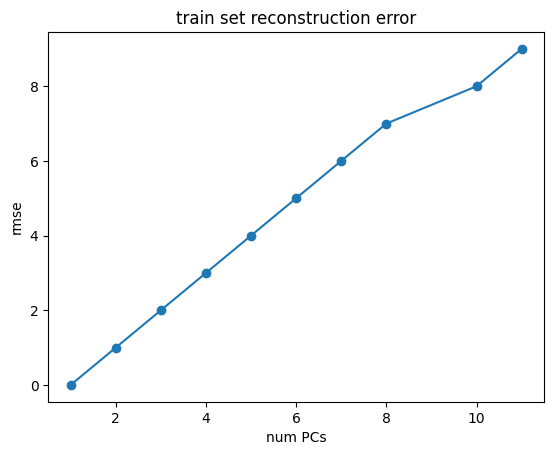

In [13]:
import matplotlib.pyplot as plt

# Fraction of variance explained
pca = PCA(n_components=X_rank)
X_transformed = pca.fit_transform(df_numerical)
evals = pca.explained_variance_  # eigenvalues in descending order

fraction_var = np.cumsum(evals[0:50] / np.sum(evals))

fig, ax = plt.subplots()
xs = Ks
ys = RMSE_train
plt.title("train set reconstruction error")
plt.xlabel("num PCs")
plt.ylabel("rmse")
ax.plot(xs, ys, marker="o")
plt.show()

In [14]:
#apply PCA (sin std)
pca = PCA(n_components=4) 
pca_result = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [15]:
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

Explained Variance Ratio: [0.21213641 0.09000128 0.08149928 0.0790624 ]


-----------------------------------------------
Percentage of explained variance per component:
-----------------------------------------------
[0.21213641 0.09000128 0.08149928 0.0790624 ]


Text(0, 0.5, 'Explained variance')

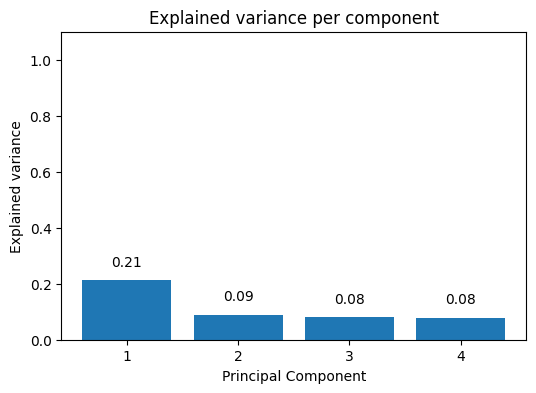

In [16]:
print('-----------------------------------------------')
print('Percentage of explained variance per component:')
print('-----------------------------------------------')
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Explained variance per component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained variance')

In [17]:
print('-------------------------------------------------------------------------')
print('Explainability per variable for each the first four principal components:')
print('-------------------------------------------------------------------------')
print(pca.components_)

-------------------------------------------------------------------------
Explainability per variable for each the first four principal components:
-------------------------------------------------------------------------
[[ 0.00901523  0.00381833 -0.05510024  0.30926595  0.48267539  0.04157388
   0.47671251 -0.04613078  0.11887926 -0.42754624 -0.26741997  0.08770411
   0.32384816  0.16428789  0.17068754]
 [-0.05074011 -0.04794546 -0.41356834  0.45694892 -0.27056207 -0.03998625
  -0.14168381  0.13600707  0.16671057  0.30180714 -0.25371241 -0.22352689
   0.44859318 -0.25967007  0.00565801]
 [ 0.00624642  0.00223088 -0.1420878  -0.2472774   0.02945022 -0.24222589
   0.02060202  0.32278696  0.42836583  0.10206146 -0.31556001  0.62054381
  -0.08421189 -0.02940853 -0.26065556]
 [ 0.11963452  0.04933884 -0.12029505 -0.09826226  0.02727599 -0.52277298
   0.11301086  0.58409683 -0.45532361 -0.05279341 -0.02901751 -0.25425632
   0.03301793  0.23327026  0.00710927]]


In [18]:
print('--------------------------------------------------------------')
print('Explainability per variable for the first PC:')
print('--------------------------------------------------------------')
# Obtener los loadings del primer componente
pc1_loadings = pca.components_[0]

# Nombres de las variables originales
variables = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]



# Crear un DataFrame con los resultados
df_loadings = pd.DataFrame({
    'Variable': variables,
    'Explainability per variable PC1': pc1_loadings
})

df_loadings

--------------------------------------------------------------
Explainability per variable for the first PC:
--------------------------------------------------------------


,Variable,Explainability per variable PC1
0,artist_id,0.009015
1,album_id,0.003818
2,duration_ms,-0.055100
3,danceability,0.309266
4,energy,0.482675
5,key,0.041574
6,loudness,0.476713
7,mode,-0.046131
8,speechiness,0.118879
9,acousticness,-0.427546


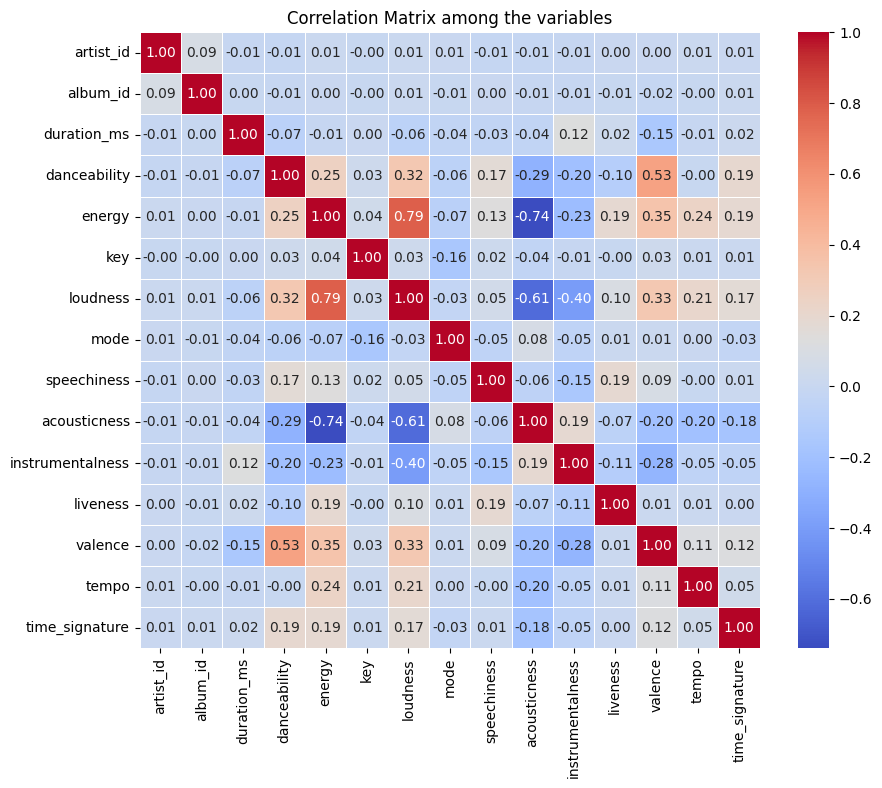

In [19]:
# Calcular la matriz de correlación
corr_matrix = df_numerical[["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]].corr()

# Crear un gráfico de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix among the variables")
plt.show()

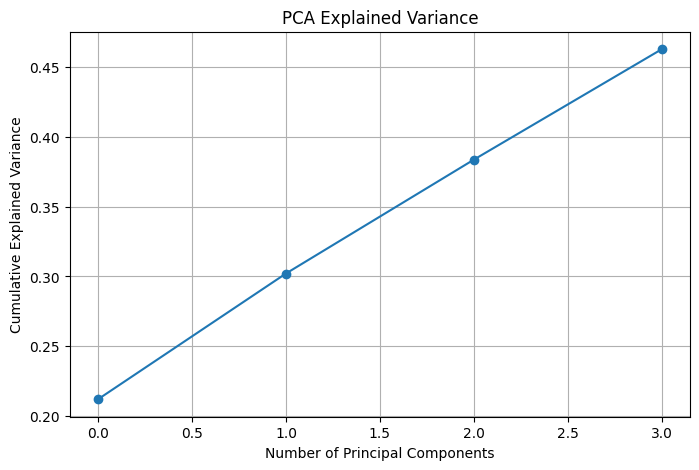

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Plot variance explained
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

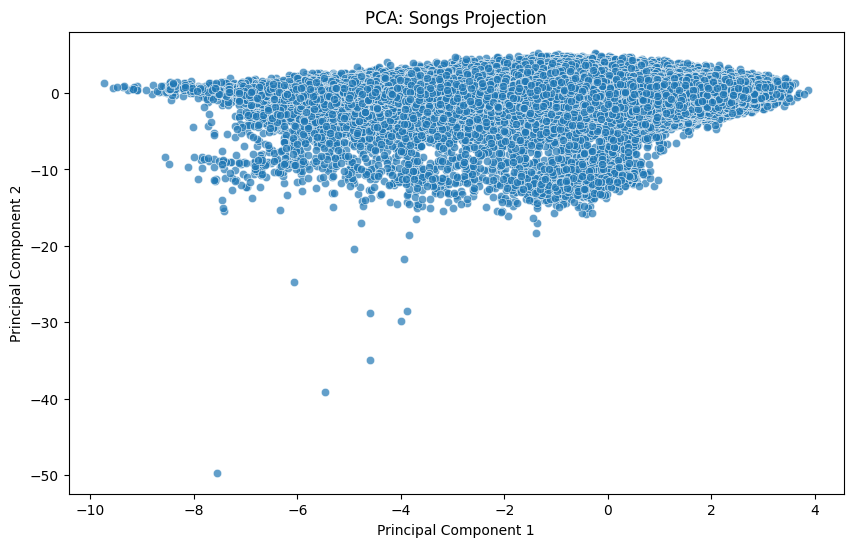

In [21]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Songs Projection')
plt.show()

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Use PCA-transformed data (PC1, PC2)
X = df_pca[['PC1', 'PC2']]

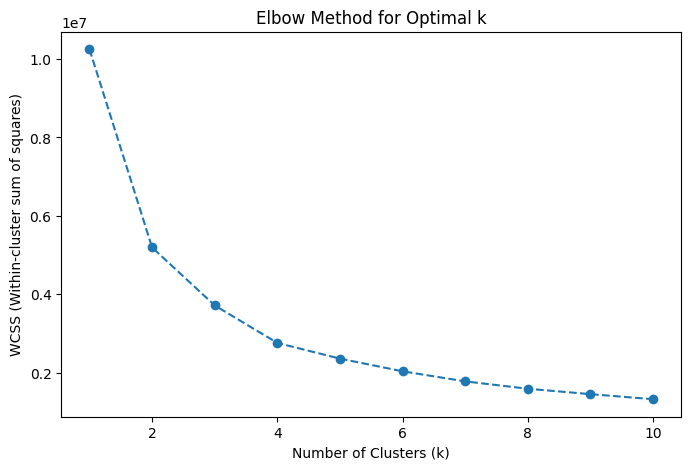

In [23]:
wcss = []  # Within-cluster sum of squares

for k in range(1, 11):  # Try k values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-cluster sum of squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [24]:
optimal_k = 4   # Change this based on elbow method results

In [25]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(X)

# Centroids
centroids = kmeans.cluster_centers_

/home/enekobarba/bigdata/bigdataenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


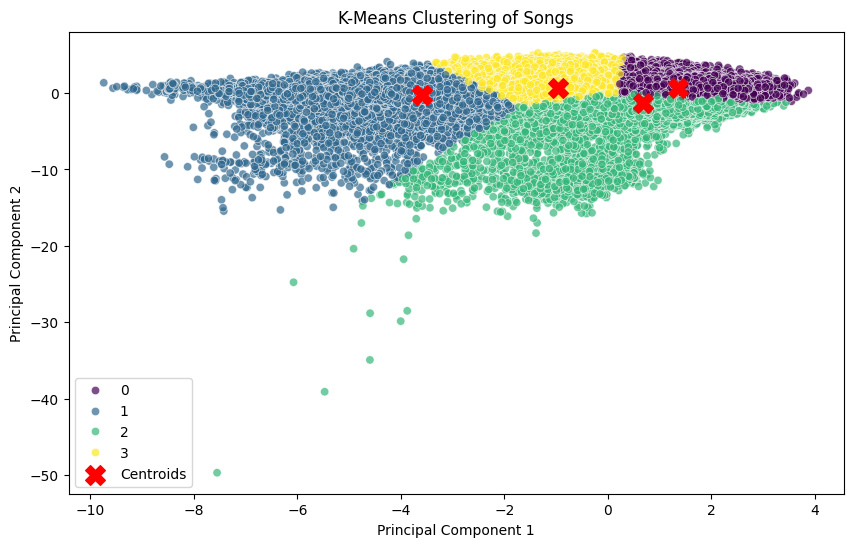

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['Cluster'], palette='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Songs')
plt.legend()
plt.show()

In [27]:
# Show 5 random songs per cluster
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(df.loc[df_pca['Cluster'] == i, ['track_name', 'artist_name']].sample(5))



Cluster 0:
                track_name                                    artist_name
1372934   Azules Y Corinto                                  Vicente Amigo
1793919          Trap Life                                Various Artists
2197046  Seguiremos Unidos  Aaron Urias El Leoncito de Ojinaga y La Furia
1918910        Upside Down                                 Civil War Rust
1048714         Holdin' On                                        Alissia

Cluster 1:
                        track_name    artist_name
352011                 The Inferno    Dave Grusin
388386   The Blues Jumped a Rabbit  The Wandering
1656947               Try Tomorrow      The Silos
2158362   Midnight Has Come & Gone   Charlie Parr
453624                        Fern    Zoë Keating

Cluster 2:
                                             track_name         artist_name
222630                                      Frustration        The Outcasts
1186920                         Firebird - Original Mix             

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Use PCA-reduced data (PC1, PC2) OR the original scaled features
X = df_scaled  # Use standardized full dataset for better representation


# Set sample size (adjust as needed)
sample_size = 10000  

# Randomly sample without replacement
df = df_numerical.sample(sample_size, random_state=42)

# Standardize the sample
df_scaled = scaler.fit_transform(df)

In [29]:
# Initialize and apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # Adjust perplexity if needed
X_tsne = tsne.fit_transform(df_scaled)

# Convert to DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['track_name'] = df_og['track_name']  # Optional: Add song names for reference
df_tsne['artist_name'] = df_og['artist_name']  # Optional: Add artist names


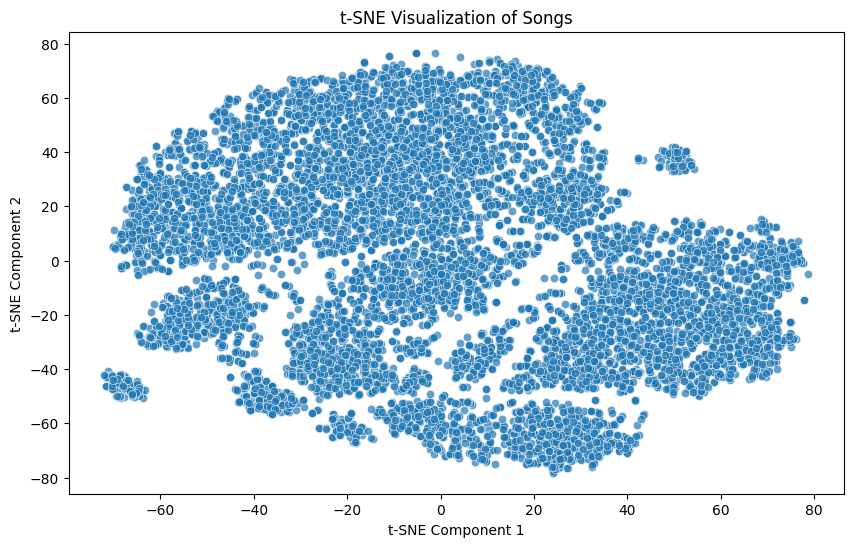

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Songs')
plt.show()


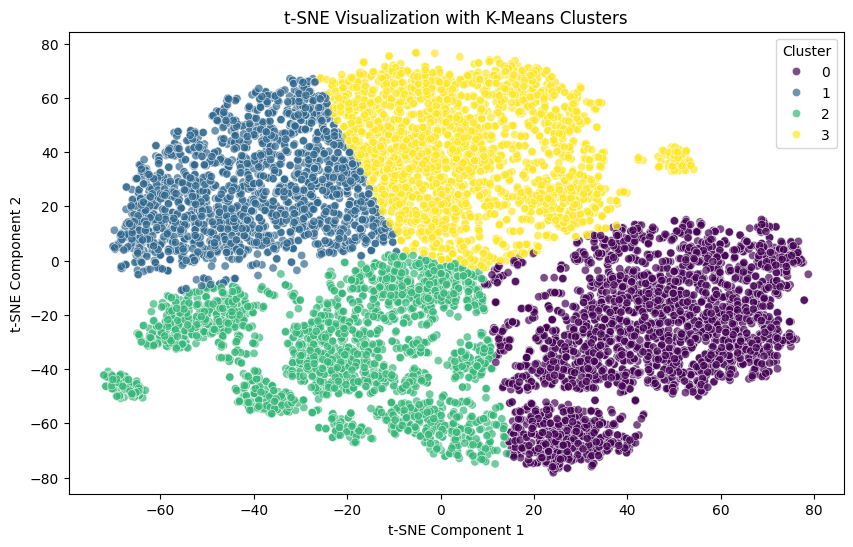

In [31]:
from sklearn.cluster import KMeans

# Apply K-Means on t-SNE output
kmeans_tsne = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_tsne['Cluster'] = kmeans_tsne.fit_predict(X_tsne)

# Plot t-SNE with Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], hue=df_tsne['Cluster'], palette='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization with K-Means Clusters')
plt.legend(title='Cluster')
plt.show()


In [32]:
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(df_tsne[df_tsne['Cluster'] == i][['track_name', 'artist_name']].sample(10))


Cluster 0:
                                             track_name        artist_name
4277                                            Lil Bit             K CAMP
5539                                  Time of Our Lives            Pitbull
9648                                        Parking Lot     Anderson .Paak
8737  Who Said - From "Hannah Montana"/Soundtrack Ve...     Hannah Montana
9425                                  R.I.P. 2 My Youth  The Neighbourhood
2637                         If You Ain't Here To Party         Luke Bryan
8725                            Behind These Hazel Eyes     Kelly Clarkson
8386                                       Three People     Willie Clayton
5549        Obsesion (No Es Amor) - Featuring Baby Bash          Frankie J
6339                           Crazy Train - Remastered      Ozzy Osbourne

Cluster 1:
                                          track_name         artist_name
8385                                     Good Loving           Jimmie Ja
4002 

In [37]:
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!sudo apt install ./google-chrome-stable_current_amd64.deb

--2025-04-02 21:28:31--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 142.251.37.46
Connecting to dl.google.com (dl.google.com)|142.251.37.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115172860 (110M) [application/x-debian-package]
Saving to: ‘google-chrome-stable_current_amd64.deb’

google-chrome-stabl 100%[===================>] 109.84M  22.0MB/s    in 5.3s    

2025-04-02 21:28:37 (20.7 MB/s) - ‘google-chrome-stable_current_amd64.deb’ saved [115172860/115172860]

[sudo] password for enekobarba: 


In [ ]:
import time
import pandas as pd
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def create_driver():
    options = uc.ChromeOptions()
    options.headless = True
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-gpu")
    options.add_argument("--window-size=1920,1080")
    options.binary_location = "/usr/bin/google-chrome"

    driver = uc.Chrome(options=options)
    return driver


def get_play_count(song_title, artist, driver):
    query = f"{song_title} {artist}".replace(" ", "%20")
    search_url = f"https://soundcloud.com/search?q={query}"

    try:
        print(f"🔎 Searching: {search_url}")
        driver.get(search_url)

        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "ul.searchList__list"))
        )

        print("✅ Search page loaded:", driver.current_url)

        spans = driver.find_elements(By.CSS_SELECTOR, "span.sc-visuallyhidden")
        for span in spans:
            text = span.text.lower()
            if "play" in text:
                return text.strip()

        print("⚠️ No play count span found.")

        with open(f"debug_{song_title[:15].replace(' ', '_')}.html", "w", encoding="utf-8") as f:
            f.write(driver.page_source)

        return None
    except Exception as e:
        print(f"Error for {song_title} - {artist}: {e}")
        with open(f"error_{song_title[:15].replace(' ', '_')}.html", "w", encoding="utf-8") as f:
            f.write(driver.page_source)
        return None

def scrape_sample(df, n=50):
    driver = create_driver()
    results = []

    sample = df.sample(n=n, random_state=42)

    for idx, row in sample.iterrows():
        title = row['track_name']
        author = row['artist_name']
        plays = get_play_count(title, author, driver)
        results.append({'title': title, 'author': author, 'play_count': plays})
        print(f"Done: {title} - {plays}")
        time.sleep(2)

    driver.quit()
    return pd.DataFrame(results)

enriched_df = scrape_sample(df_todo_util, n=50)
enriched_df.to_csv("soundcloud_plays_sample.csv", index=False)


🔎 Searching: https://soundcloud.com/search?q=The%20Note%20I%20Left%20Leaf%20Dog
❌ Error for The Note I Left - Leaf Dog: Message: 
Stacktrace:
#0 0x55cd2f0d6e6a <unknown>
#1 0x55cd2eb88640 <unknown>
#2 0x55cd2ebd9b5a <unknown>
#3 0x55cd2ebd9d51 <unknown>
#4 0x55cd2ec28344 <unknown>
#5 0x55cd2ebff77d <unknown>
#6 0x55cd2ec257b5 <unknown>
#7 0x55cd2ebff523 <unknown>
#8 0x55cd2ebcbef3 <unknown>
#9 0x55cd2ebccb51 <unknown>
#10 0x55cd2f09bd2b <unknown>
#11 0x55cd2f09fc01 <unknown>
#12 0x55cd2f083512 <unknown>
#13 0x55cd2f0a0774 <unknown>
#14 0x55cd2f06790f <unknown>
#15 0x55cd2f0c4fb8 <unknown>
#16 0x55cd2f0c5196 <unknown>
#17 0x55cd2f0d5cb6 <unknown>
#18 0x7f2cdee43ac3 <unknown>

Done: The Note I Left - None


KeyboardInterrupt: 

### Recommendations to user content-based

In [ ]:
UID=1

se supone que se le recomiendan unas canciones y les da like o no o super

dislike: -1
like: 1
saltar: 0
super like :2

In [ ]:
global ratings

In [ ]:
ratings=pd.DataFrame( columns=["user", "track_id", "rating"])

In [ ]:
rating_map = {
    "dislike": -1,
    "like": 1,
    "saltar": 0,
    "super like": 2
}


while ratings.shape[0] < 20:
    num_aleatorio = random.randint(0, len(df) - 1)
    
    #info de canción
    try:
        cancion = df.loc[num_aleatorio]
        nombre_cancion = cancion['track_name']
        artista = cancion['artist_name']
    except (KeyError, IndexError):
        nombre_cancion = "Canción desconocida"
        artista = "Artista desconocido"

    
    while True:
        input_usuario = input(f"\n🎵 Canción: {nombre_cancion} - {artista}\n""Ingrese su calificación (dislike/like/saltar/super like): ").strip().lower()        
        if input_usuario in rating_map:
            rating = rating_map[input_usuario]
            break
        else:
            print("⚠️ Entrada inválida. Ingrese una opción válida: dislike, like, saltar, super like.")

    nueva_fila = [UID, num_aleatorio, rating]
    ratings.loc[ratings.shape[0]] = nueva_fila


dislike: -1
like: 1
saltar: 0
super like :2

In [ ]:
ratings

In [ ]:
!pip install umap-learn
!pip install numpy==2.1.0 --force-reinstall --upgrade

In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import umap.umap_ as umap
import os

In [ ]:
# Before generating recommendations, ensure df_scaled uses the full dataset
numerical_features = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

# Use the full dataset for scaling and PCA
scaler = StandardScaler()
df_scaled_full = scaler.fit_transform(df_numerical[numerical_features])  # Full dataset

pca = PCA(n_components=4)
reduced_features_full = pca.fit_transform(df_scaled_full).astype(np.float32)

### He intentado lo de estas celdas pero peta

In [ ]:
def reduce_features(df, numerical_features, n_components=5):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[numerical_features])
    try:
        reducer = umap.UMAP(
            n_components=n_components,
            metric='cosine',
            n_neighbors=10,
            low_memory=True,
            random_state=42
        )
        reduced = reducer.fit_transform(df_scaled).astype(np.float32)
    except Exception as e:
        reducer = PCA(n_components=n_components)
        reduced = reducer.fit_transform(df_scaled).astype(np.float32)

    return df_scaled, reduced

In [14]:
numerical_features = [
    "artist_id", "album_id", "duration_ms", "danceability", "energy", "key",
    "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature"
]

In [10]:
df_others.head()

,track_uri,artist_uri,album_uri,type,uri,id,fduration_ms,track_href,analysis_url
track_id,,,,,,,,,
143810,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,audio_features,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0UaMYEvWZi0ZqiDOoHU3YI,226864,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...
1827850,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,audio_features,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak,198800,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...
154482,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,audio_features,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,0WqIKmW4BTrj3eJFmnCKMv,235933,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...
341116,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,spotify:album:6QPkyl04rXwTGlGlcYaRoW,audio_features,spotify:track:1AWQoqb9bSvzTjaLralEkT,1AWQoqb9bSvzTjaLralEkT,267267,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...
516741,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,spotify:album:6NmFmPX56pcLBOFMhIiKvF,audio_features,spotify:track:1lzr43nnXAijIGYnCT8M8H,1lzr43nnXAijIGYnCT8M8H,227600,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...


In [20]:
popularity= track["popularity"]
release_date_album = track["album"]["release_date"]
is_explicit = track["explicit"]
image_url = track["album"]["images"][0]["url"]

print(popularity)
print(release_date_album)
print(is_explicit)
print(image_url)

68
2005-07-04
True
https://i.scdn.co/image/ab67616d0000b273f1dfae21eaac0d24fb3dcf5a


In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Configura tus credenciales (registra una app en https://developer.spotify.com/dashboard)
client_id = "1e6d532d63fa4fbb82230cd1ffd06fc9"
client_secret = "b6281e5bb26c43d282e1a4987828366c"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
))
# Lista para almacenar las popularidades
popularities = []

# Iterar sobre cada track en df_others
for track_uri in df_others["track_uri"]:
    try:
        track_id = track_uri.split(":")[-1]  # ¡Aquí estaba el error principal!
        # Obtener los datos del track
        track = sp.track(track_id)        
        #popularities.append(popularity)
        print(track)
            
    except Exception as e:
        #print(f"Error al obtener popularidad para {track_uri}: {str(e)}")
        print(track)
        #popularities.append(None)  # Añadir None si hay error
    break



# Mostrar el resultado
#print("\nDataFrame con popularidad añadida:")
#print(df_numerical.head())

{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2wIVse2owClT7go1WT98tk'}, 'href': 'https://api.spotify.com/v1/artists/2wIVse2owClT7go1WT98tk', 'id': '2wIVse2owClT7go1WT98tk', 'name': 'Missy Elliott', 'type': 'artist', 'uri': 'spotify:artist:2wIVse2owClT7go1WT98tk'}], 'available_markets': ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR', 'ME', 'MK', 'RS', 'SI', 'KR', 'BD', 'PK', 'LK', 'GH', 'KE', 'NG', 'TZ', 'UG', 'AG', 'AM', 'BS', 'BB', 'BZ', 'BT', 'BW', 'BF', 'CV', '

In [ ]:
numerical_features = [
    "artist_id", "album_id", "duration_ms", "danceability", "energy", "key",
    "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature"
]

df_scaled_full, reduced_features_full = reduce_features(df_numerical, numerical_features)

### Esto ya va bien

In [ ]:
# Rebuild the NearestNeighbors model with the full dataset
nn_model_full = NearestNeighbors(
    n_neighbors=50,
    metric='cosine',
    algorithm='auto',
    n_jobs=-1
).fit(reduced_features_full)


In [ ]:
def content_based_recommendation(user_ratings, df_original, df_scaled, reduced_features, 
                               top_n=10, diversity=0.7, batch_size=100):
    """
    Sistema de recomendación basado en contenido mejorado con:
    - Manejo de dataset completo
    - Mapeo correcto de índices
    - Diversidad de recomendaciones
    """
    # 1. Preparar datos y modelos
    nn_model = NearestNeighbors(n_neighbors=50, metric='cosine', algorithm='auto', n_jobs=-1).fit(reduced_features)
    df_original_reset = df_original.reset_index()
    track_id_to_idx = {track_id: idx for idx, track_id in enumerate(df_original_reset['track_id'])}
    
    # 2. Filtrar y mapear calificaciones válidas
    valid_ratings = user_ratings[user_ratings['track_id'].isin(df_original_reset['track_id'])].copy()
    if valid_ratings.empty:
        return df_original_reset.sample(min(top_n, len(df_original_reset)))
    
    valid_ratings['track_idx'] = valid_ratings['track_id'].map(track_id_to_idx)
    valid_ratings = valid_ratings.dropna(subset=['track_idx'])
    
    # 3. Configurar pesos y exclusiones
    #rating_weights = valid_ratings['rating'].map({-2: -2.0, -1: -1.0, 0: 0.0, 1: 1.0, 2: 2.0})
    weight_map = {-1: -1.0, 0: 0.0, 1: 1.0, 2: 2.0}
    rating_weights = valid_ratings['rating'].map(weight_map)
    track_indices = valid_ratings['track_idx'].astype(int).values
    weights = rating_weights.values
    
    # 4. Búsqueda por lotes de vecinos similares
    all_scores = np.zeros(reduced_features.shape[0])
    rated_tracks = set()
    
    for i in range(0, len(track_indices), batch_size):
        batch_indices = track_indices[i:i + batch_size]
        batch_weights = weights[i:i + batch_size]
        
        distances, indices = nn_model.kneighbors(reduced_features[batch_indices])
        similarities = 1 / (1 + distances)
        weighted_scores = similarities * batch_weights[:, np.newaxis]
        
        # Actualizar puntuaciones acumuladas
        np.add.at(all_scores, indices.ravel(), weighted_scores.ravel())
        rated_tracks.update(batch_indices.tolist())
    
    # 5. Aplicar diversidad y exclusión
    noise = (np.random.rand(len(all_scores)) - 0.5) * 2 * diversity * np.mean(np.abs(all_scores))
    final_scores = all_scores * (1 - diversity) + noise
    
    # Excluir tracks ya calificados
    final_scores[list(rated_tracks)] = -np.inf
    
    # 6. Obtener mejores recomendaciones
    top_indices = np.argsort(final_scores)[-top_n:][::-1]
    valid_indices = top_indices[final_scores[top_indices] > -np.inf]
    
    if len(valid_indices) == 0:
        return pd.DataFrame(columns=df_original.columns)
    
    return df_original_reset.iloc[valid_indices].set_index('track_id')


In [ ]:
#recomendar
recommendations = content_based_recommendation(
    user_ratings=ratings,
    df_original=df,
    df_scaled=df_scaled_full,
    reduced_features=reduced_features_full,
    top_n=5,
    diversity=0.3
)

print("Recommendations:")
print(recommendations[['track_name', 'artist_name']])

# Otros

## PC3, PC4

In [ ]:
df_pca_34 = pd.DataFrame(df_pca[:, 2:], columns=['PC3', 'PC4'])

In [ ]:
#KMeans with k=10
kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(df_pca_34)

In [ ]:
# Visualización corregida
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_34['PC3'], df_pca_34['PC4'], c=df['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and PCA')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.colorbar(label='cluster')
plt.show()

## Spark

### Spark Dataframe

In [ ]:
#columns for clustering
feature_columns = ["danceability", "energy", "key", "loudness", "mode",
                   "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")
assembled_df = assembler.transform(spark_df).repartition(500).cache()
assembled_df.count()

### Intento de KMeans con Spark

In [ ]:
schema = StructType([
    StructField("track_uri", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("artist_name", StringType(), True),
    StructField("album_name", StringType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("danceability", FloatType(), True),
    StructField("energy", FloatType(), True),
    StructField("key", IntegerType(), True),
    StructField("loudness", FloatType(), True),
    StructField("mode", IntegerType(), True),
    StructField("speechiness", FloatType(), True),
    StructField("acousticness", FloatType(), True),
    StructField("instrumentalness", FloatType(), True),
    StructField("liveness", FloatType(), True),
    StructField("valence", FloatType(), True),
    StructField("tempo", FloatType(), True),
    StructField("time_signature", IntegerType(), True)
])

spark_df = spark.createDataFrame(df, schema=schema)

spark_df.show(5)

In [ ]:
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df).select("features").cache()
scaled_df.count()

In [ ]:
#KMeans with 10 clusters
kmeans = KMeans(k=10, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(scaled_df)

In [ ]:
#predictions
clustered_df = model.transform(assembled_df)

In [ ]:
#plotting the clusters
pandas_df = clusters_df.select("danceability", "energy", "cluster").toPandas() #transform to pandas for plotting
plt.figure(figsize=(10, 6))
for cluster in range(10):
    cluster_data = pandas_df[pandas_df['cluster'] == cluster]
    plt.scatter(cluster_data['danceability'], cluster_data['energy'], label=f'Cluster {cluster}')

plt.title('Clustering de canciones por danceability y energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.legend()
plt.show()